# The Effects of Lifestyle Based Variables on the Math Grades of Students

### Introduction

This group will be examining factors influencing student performance in Portuguese secondary students to attempt to answer the question of which factor is most influential in promoting good grades. We will be approaching this problem using classification techniques in R. The student achievement data was collected from 2 Portuguese secondary schools and assessed performance in mathematics. The data includes the target variable (student grades during periods 1, 2, and 3) in addition to 30 predictor variables. For the purposes of this project, we have chosen 3 variables with numerical values to be able to determine the answer to our question. The 3 variables are hours of free time, hours of study time, and number of school absences. Moreover, the data originally comes in an excel sheet format which will need to be considered when reading the data set into R. The data can be accessed through the link below Data set: https://archive.ics.uci.edu/dataset/320/student+performance Data set source: UC Irvine Machine Learning Repository

### Reading in the Data

Here, we read in the data from our GitHub repository. The original dataset is from the UC Irvine Machine Learning Repository, but for reproducibility, we will read it in from a GitHub URL. This is what we have done below, using `read_csv2` to read in the data, as it uses a semi-colon as a delimiter. We use `head` to display the first 6 lines of our dataset.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(2020)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://raw.githubusercontent.com/chloezandberg/dsci-100-project/main/student-mat.csv"
math_data <- read_csv2(url)
head(math_data)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


### Wrangling the Data

Below, we clean the data by selecting only the predictor variables that we will use in our classification problem, `freetime`, `studytime`, and `absences`, and the variable we intend to predict, `G3`. For context, G3 is the final grade in the Portuguese school system. Next, we calculate `G3` as a percentage (as G3 is reported out of 20 in the Portuguese school system). Finally, we recoded the final grade percentages according to the UBC grading scheme to be letter grades for our classification problem. We use `head` to display the first six rows of our clean data. See the first 6 rows of our clean data, Table 1, below.

In [3]:
clean_math_data <- math_data |>
    select(freetime, studytime, absences, G3) |> # G3 is final grade in Portugese school system
    mutate(final_percentage = (G3/20)*100) |> # final grade is out of 20
    mutate(letter_grade = cut(final_percentage, c(-1, 49, 54, 67, 79, 100))) |> # recoding to be letter grade levels for classification problem
    mutate(letter_grade = recode(letter_grade,                                  # had to set lower limit to -1 to include grades of 0%
                                           "(-1,49]" = "F",
                                           "(49,54]" = "D",
                                           "(54,67]" = "C",
                                           "(67,79]" = "B",
                                           "(79,100]" = "A")) |> 
    select(freetime, studytime, absences, letter_grade) |>
    drop_na()
                                           
head(clean_math_data)
print('Table 1: First 6 rows of clean dataset')

freetime,studytime,absences,letter_grade
<dbl>,<dbl>,<dbl>,<fct>
3,2,6,F
3,2,4,F
3,2,10,D
2,3,2,B
3,2,4,D
4,2,10,B


[1] "Table 1: First 6 rows of clean dataset"


### Exploratory Data Analysis

Below, we explore our clean dataset by counting up how many students received each letter grade. We do this by grouping our dataset by letter grade (`letter_grade`), using `group_by`. Then, we use `summarize` to count the number of rows (or observations) of each letter grade to get their respective counts (see Table 2 below). We also explore our data by finding the average of each predictor variable using `map_df`, and renaming each column to reflect this. Finally, we count up the total number of observations in our dataset and report this with the average of each predictor (see Table 3 below).

In [57]:
avg_predictors <- clean_math_data |>
            select(freetime, studytime, absences) |>
            map_df(mean) |>
            rename("avg_freetime" = "freetime", # renaming each column to reflect that each column is now the average of each predictor variable
                   'avg_studytime' = 'studytime',
                   'avg_absences' = 'absences')

count_observations <- nrow(clean_math_data) # counting number of observations in the dataset

count_class <- clean_math_data |>
            group_by(letter_grade) |>
            summarize(count = n()) # counting how many instances occur of each letter grade, grouped by letter_grade

observations_tibble <- tibble(number_observations = count_observations)

prop_class <- count_class |>
                mutate(proportion = count/395)
prop_class
print('Table 2: Count of each letter grade (A, B, C, D, or F) and proportion for each grade')

exploratory_data_analysis <- bind_cols(observations_tibble, avg_predictors) # binding the total number of observations with the average of each predictor

exploratory_data_analysis
print('Table 3: Total number of observations and the means of each predictor variable')

letter_grade,count,proportion
<fct>,<int>,<dbl>
F,130,0.3291139
D,56,0.1417722
C,109,0.2759494
B,60,0.1518987
A,40,0.1012658


[1] "Table 2: Count of each letter grade (A, B, C, D, or F) and proportion for each grade"


number_observations,avg_freetime,avg_studytime,avg_absences
<int>,<dbl>,<dbl>,<dbl>
395,3.235443,2.035443,5.708861


[1] "Table 3: Total number of observations and the means of each predictor variable"


### Visualizing the Data

Below, we create several visualizations to get a sense of what our data looks like prior to our analysis. First, we create `math_plot` which is a bar chart that helps us investigate which of the final grades are most common of the 5 (A, B, C, D, and F). Next, we create `absences_dist` which is a bar chart that helps us investigate what the distribution of absences look like for students. After this, we create `freetime_dist` which plots the distribution of each level of free time a student has (on a scale from 1-4). Finally, we create `studytime_dist` which plots the distribution of the amount of study time each student has.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


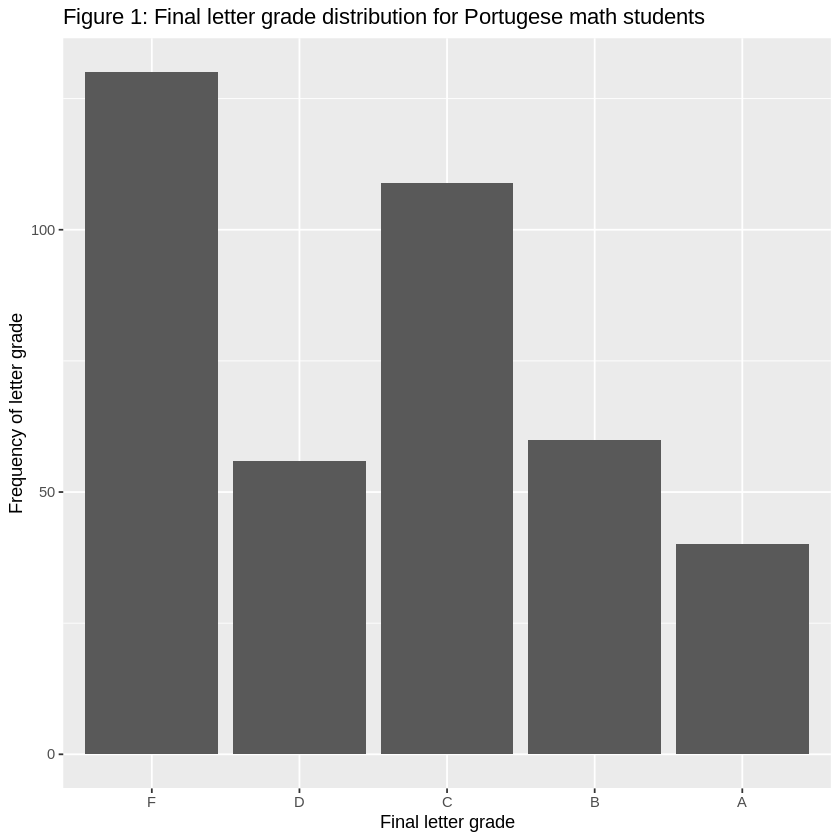

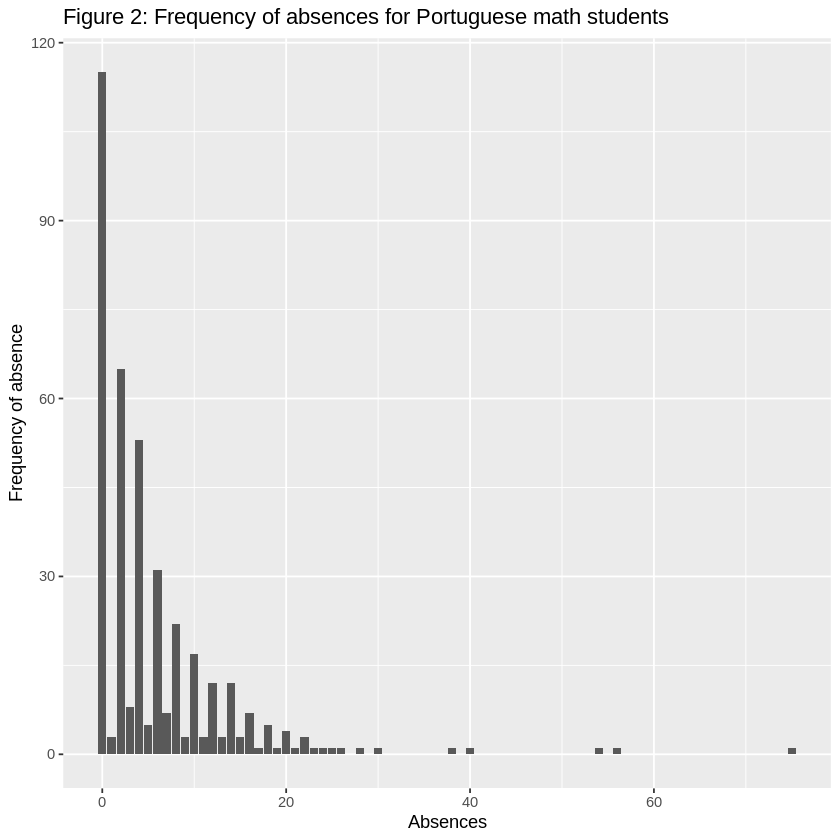

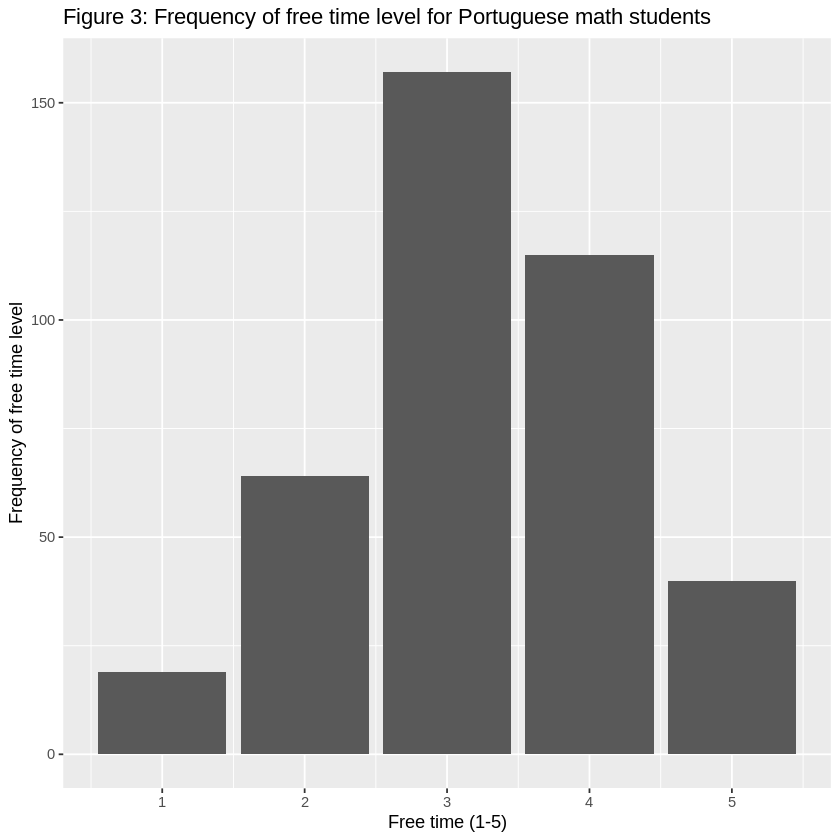

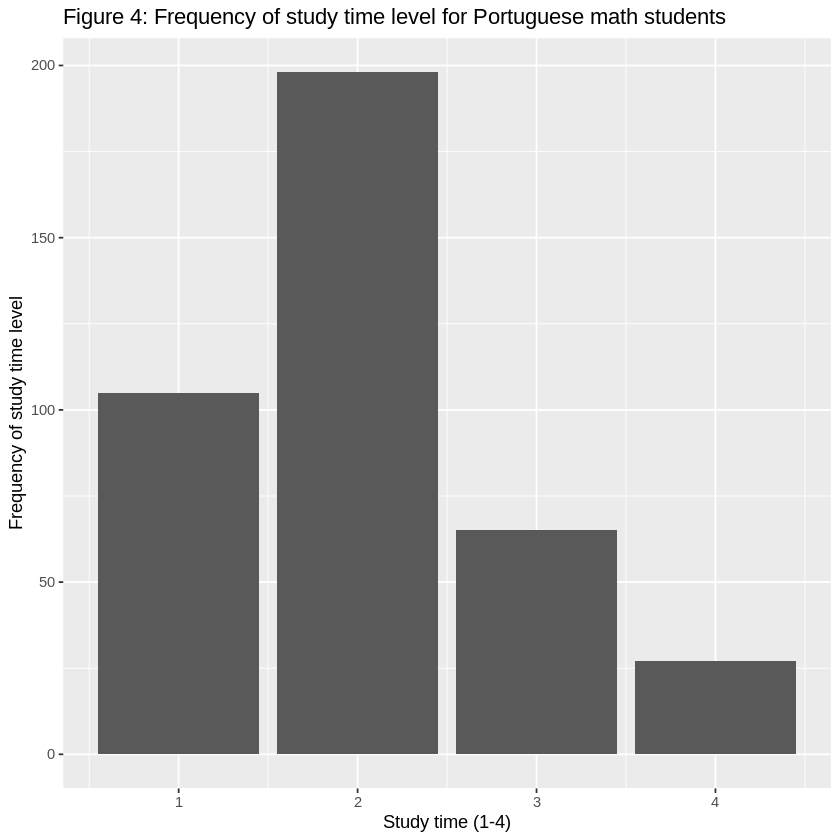

In [5]:
math_plot <- ggplot(clean_math_data, aes(x=letter_grade)) +
                geom_histogram(stat='count') +
                labs(x="Final letter grade",
                y="Frequency of letter grade") +
                ggtitle("Figure 1: Final letter grade distribution for Portugese math students") # investigate which grades are most common

absences_dist <- ggplot(clean_math_data, aes(x=absences)) + #  number of school absences (numeric: from 0 to 93)
                    geom_histogram(stat='count') +
                    labs(x='Absences',
                         y='Frequency of absence') +
                        ggtitle('Figure 2: Frequency of absences for Portuguese math students')

freetime_dist <- ggplot(clean_math_data, aes(x=freetime)) + # free time after school (numeric: from 1 - very low to 5 - very high)
                    geom_bar(stat='count') +
                    labs(x='Free time (1-5)',
                         y='Frequency of free time level') +
                        ggtitle('Figure 3: Frequency of free time level for Portuguese math students')

studytime_dist <- ggplot(clean_math_data, aes(x=studytime)) + # weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
                    geom_bar(stat='count') +
                    labs(x='Study time (1-4)',
                         y='Frequency of study time level') +
                        ggtitle('Figure 4: Frequency of study time level for Portuguese math students')

math_plot
absences_dist
freetime_dist
studytime_dist

Below are two more visualizations that provide initial insight into the relationships between the variables `absences`, `studytime`, and `freetime`, and the letter grades generally associated with them. Before even using the classification model, it can be helpful to see what it is using as its basis for information, so that is what these graphs are for. Figure 5 shows the relationships between `absences` and `freetime`, and Figure 6 represents the amount of `studytime` to `absences`. 

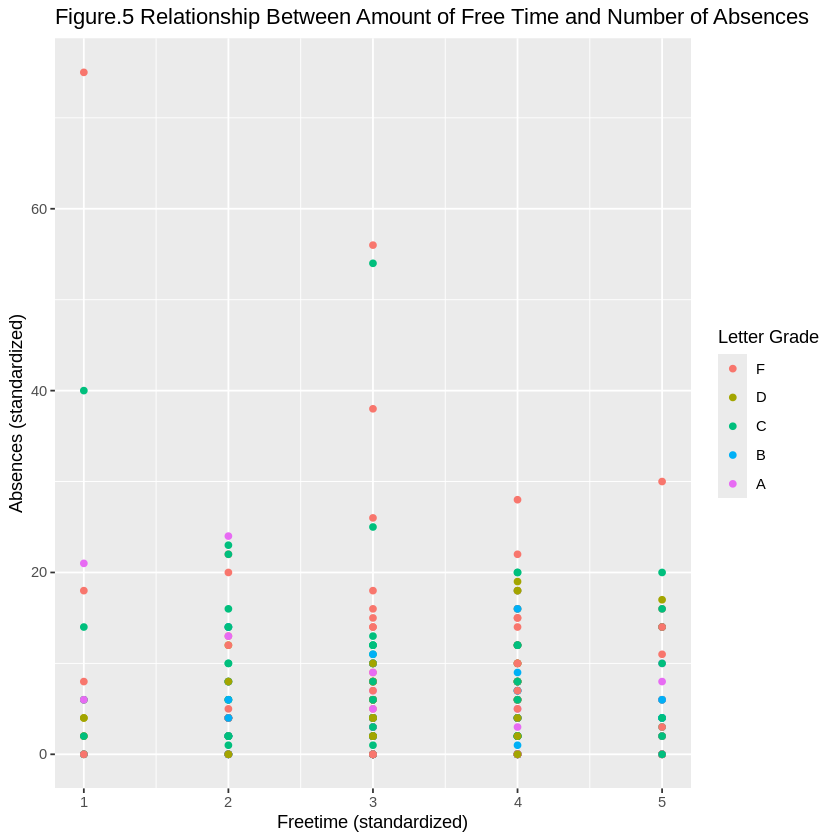

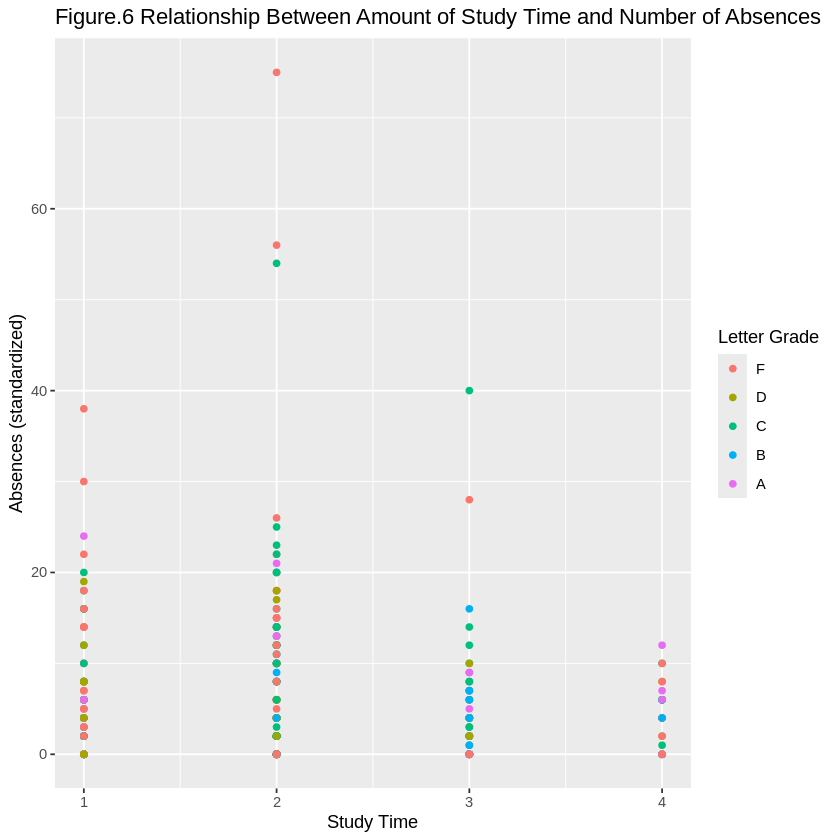

In [36]:
clean_math_plot<-ggplot(clean_math_data, aes(x= freetime, y=absences, colour = letter_grade))+
geom_point()+
labs(x = "Freetime (standardized)", y = "Absences (standardized)", color = "Letter Grade")+
ggtitle("Figure.5 Relationship Between Amount of Free Time and Number of Absences")
clean_math_plot

clean_math_plot2<-ggplot(clean_math_data, aes(x= studytime, y=absences, colour = letter_grade))+
geom_point()+
labs(x = "Study Time", y = "Absences (standardized)", color = "Letter Grade")+
ggtitle("Figure.6 Relationship Between Amount of Study Time and Number of Absences")
clean_math_plot2

## K-NN Classification Analysis

To perform our analysis, we will use the K-NN Classification algorithm, choosing our K-nearest neighbours based on which one maximizes accuracy. We choose to maximize accuracy, as it doesn't make sense to focus on recall or precision as there isn't one particular letter grade that we are particularly interested in. We will achieve this by splitting our data into a testing and training set, and performing multiple iterations of the K-nearest neighbours classification algorithm with K ranging from 1-10. Out of these 10 different K-neighbours, we will choose the one maximizing accuracy, and take this to be our optimal K. This is the model we will use to predict the letter grades based on the `freetime`, `studytime` and `absence` data from our `clean_math_data` dataset.

## Splitting the data into a training and test set

We will split the `clean_math_data` into a training set (75%) and a testing set (25%). Once the test set is created, we will put it in a lockbox and not use it again until we have optimized the K-nn classifier using the training set. The variable `letter_grade` will serve as our class label.

To create the training and test set, first we use the initial_split function to split clean_math_data. We want to use 75% of the data. For the strata argument, place the variable we want to classify, letter_grade. Name the object we create math_split. Next, pass the math_split object to the training and testing functions and name respective objects math_train and math_test.

In [23]:
set.seed(2020)
math_split <- initial_split(clean_math_data, prop = 0.75, strata = letter_grade)  
math_train <- training(math_split)   
math_test <- testing(math_split)

The K-nearest neighbors is sensitive to the scale of the predictors, necessitating preprocessing to standardize them. It's crucial to use only the training data to define the preprocessing steps in our recipe, ensuring that the test data does not influence the model training in any way. After establishing the standardization preprocessor, it can then be applied to both the training and test data sets separately.

To scale and center the data, we will begin by inputting the vector of predictors into the recipe function. For scaling the predictors, use the `step_scale(all_predictors())` function. To center the predictors, use the `step_center(all_predictors())` function.

In [43]:
set.seed(2020)

math_recipe <- recipe(letter_grade ~ absences + studytime + freetime, data = math_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
math_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



We've successfully split our data into training and testing sets and have preprocessed the data. Now, using the `tidymodels` package, we will build our K-nearest neighbors classifier exclusively with the training set. To start, we define the classifier by setting K=5 neighbours and opt for the straight-line distance method.

In [44]:
set.seed(2020)

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
              set_engine("kknn") |>
              set_mode("classification")

Next, we train the classifier with the training data set using the workflow function.

In [45]:
math_fit <- workflow() |>
       add_recipe(math_recipe) |>
       add_model(knn_spec_2) |>
       fit(data = math_train)
math_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5966102
Best kernel: rectangular
Best k: 5

Now that our K-nearest neighbor classifier object is ready, we can proceed with predicting the class labels for our test set.

In [46]:
set.seed(2020) 

math_test_predictions <- predict(math_fit, math_test) |>
    bind_cols(math_test)
math_test_predictions
print('Table 4: Predicted class bound with the original test set for our K-NN classifier arbitrarily using K=5')

.pred_class,freetime,studytime,absences,letter_grade
<fct>,<dbl>,<dbl>,<dbl>,<fct>
D,3,2,4,D
F,5,1,16,F
F,2,1,4,B
⋮,⋮,⋮,⋮,⋮
F,1,2,0,B
B,4,2,2,D
F,4,3,0,F


[1] "Table 4: Predicted class bound with the original test set for our K-NN classifier arbitrarily using K=5"


Next, we will evaluate initial model performance by using the `metrics()` function to calculate how well our model is performing with its current settings. We will filter the metrics down just to accuracy, as this is the metric we decided we are interested in.

In [47]:
initial_metrics <- metrics(math_test_predictions, truth = letter_grade, estimate = .pred_class) |>
                  filter(.metric == "accuracy")
initial_metrics
print('Table 5: Estimate of accuracy for our K-NN classifier arbitrarily using K=5')

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.24


[1] "Table 5: Estimate of accuracy for our K-NN classifier arbitrarily using K=5"


We can see our K-NN classifier with K=5 neighbours achieved an accuracy of 24.0% Now, we examine the prediction errors. A confusion matrix is a useful tool for understanding the types of errors our model is making. It shows the counts of true positives, true negatives, false positives, and false negatives.

In [48]:
math_mat <- conf_mat(math_test_predictions, truth = letter_grade, estimate = .pred_class)
math_mat
print('Table 6: The confusion matrix for our K-NN classifier arbitrarily using K=5')

          Truth
Prediction  F  D  C  B  A
         F  9  3  9  5  4
         D  5  2  4  1  0
         C  5  1  7  2  3
         B 12  6  6  4  1
         A  2  2  2  3  2

[1] "Table 6: The confusion matrix for our K-NN classifier arbitrarily using K=5"


## Tuning our classifier

Instead of arbitrarily picking the number of neighbours as we did above, we will tune our classifier instead use a process called cross-validation. In cross-validation, we split our training data into $C$ folds, where 1 fold acts as the validation set, and the other $C-1$ folds act as the training sets. We evaluate the accuracy of the classifier $C$ times and take the average of those accuracies to get a more robust estimation of the performance of our model. Here, we use $C$ = 5 folds. More folds are better, but they also take up more computational power. We set the `strata` argument to the `letter_grade` variable to ensure that the training and validation subsets contain the right proportions for each category of observation.

In [49]:
math_vfold <- vfold_cv(math_train, v = 5, strata = letter_grade)

The code beneath is to specify a new model that is tuned to help determine the best $K$ value to use for data analysis on this data set. First, it creates a new engine, `knn_tune`, then it uses that engine to find the accuracy of predictions given values of $K$, `grid`. Here, we will make an object called `k_vals` that is a vector containing the numbers $1-10$, as we would like to test the accuracy of $K=1$ to $K=10$. We will set the `grid` argument in `fit_resamples` to `k_vals` in order to do this. Finally, we will assess each value of $K$ using the `collect_metrics` function and filtering for `accuracy`.

In [50]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode("classification")
knn_tune

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
      add_recipe(math_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = math_vfold, grid = k_vals) |>
      collect_metrics() |>
        filter(.metric == 'accuracy') # filtering just for accuracy since this is the metric we are interested in
knn_results
print('Table 7: Accuracy estimates for 5-fold cross-validation on our training set using K=1 to K=10')

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.1966459,5,0.01841164,Preprocessor1_Model01
2,accuracy,multiclass,0.1894159,5,0.03307164,Preprocessor1_Model02
3,accuracy,multiclass,0.2436141,5,0.02175267,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.3353495,5,0.008425577,Preprocessor1_Model08
9,accuracy,multiclass,0.3354588,5,0.009518408,Preprocessor1_Model09
10,accuracy,multiclass,0.3481138,5,0.028098693,Preprocessor1_Model10


[1] "Table 7: Accuracy estimates for 5-fold cross-validation on our training set using K=1 to K=10"


### Determining the best $K$

This graph represents the accuracy of the model's predictions as the number of neighbours increases. Given that it seems to plateau in accuracy at around 10 neighbours with an accuracy of ~0.35%, we will use $K = 10$ in our analysis. 

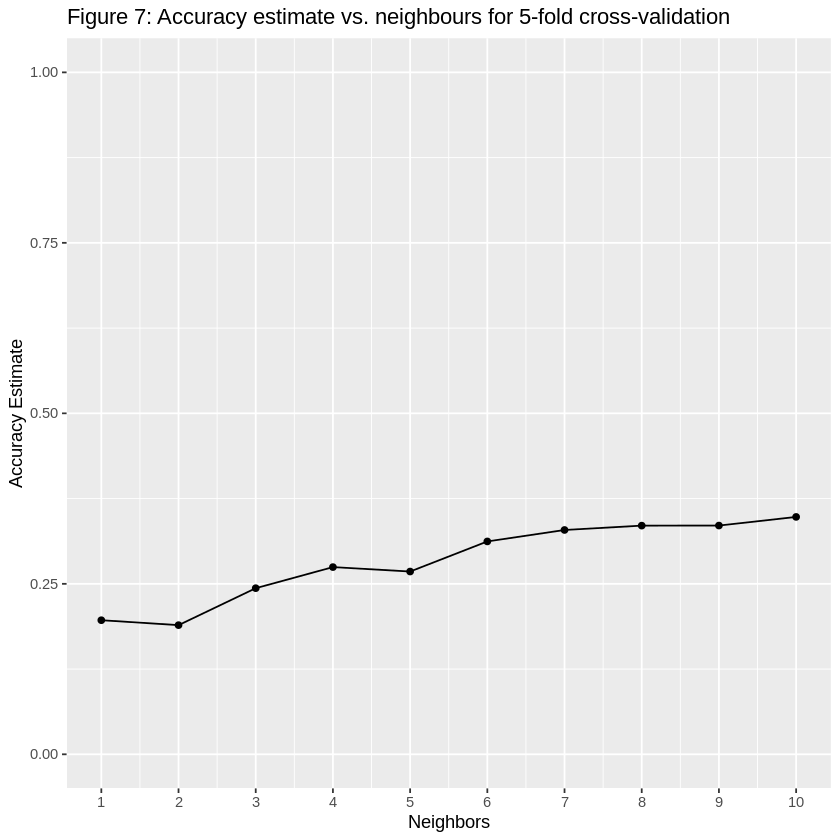

In [58]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
        geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0, 1.0)) + # adjusting the y-axis
        ggtitle('Figure 7: Accuracy estimate vs. neighbours for 5-fold cross-validation')

accuracy_versus_k

Below is the code used for the final analysis, with the new, most optimal $K$ value. We create an object called `knn_spec2` that uses the most optimal $K=10$. Then, we summarize the accuracy of our classifier against our testing data, `math_test`, that we initially made in our initial split in `knn_final_results`. Here, we reuse the recipe we made in the beginning, but we use our new model, `knn_spec2` instead of the arbitrary one from before. After fitting our workflow to our training data, we make predictions on our testing data using the `predict` function. We bind the predictions with the original testing data, and calculate the accuracy of our classifier using the `metrics` function, where we specify the true classes of each observation in our test set to be `letter_grade`. After filtering for `accuracy`, we are left with Table 8 which shows the accuracy of our new classifier against the testing data. The accuracy of our classifier is 27%.

In [56]:
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_final_results <- workflow() |>
      add_recipe(math_recipe) |> # recipe remains unchanged
      add_model(knn_spec2) |>  # newest spec using optimal K=10
      fit(data = math_train) |>
    predict(math_test) |>
    bind_cols(math_test) |>
      metrics(truth = letter_grade, estimate = .pred_class) |>
      filter(.metric == "accuracy") # filtering just for accuracy since this is the metric we are interested in
knn_final_results
print('Table 8: Accuracy estimate for K=10 classifier tested against testing set')

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.27


[1] "Table 8: Accuracy estimate for K=10 classifier tested against testing set"


## Conclusion
In the end, we achieved an accuracy of 27% which is not nearly as high as we'd hoped for. In fact, if we refer back to our exploratory data analysis, the proportion of F's in the original data set was 0.3291139 or approximately 32.9%. If we had simply tuned our classifier to predict F for every observation (used a majority classifier that underfits the data with an absurdly large $K$), we would have achieved a higher accuracy than the accuracy we achieved. In this case, we can suspect many things went wrong in our analysis. For one, we can suspect that the predictors we chose for our model may not be the best for predicting letter grade. We can also suspect that because two of the variables we used as predictors, `studytime` and `freetime`, were discrete values representing different ranges of hours, these variables did not contribute meaningfully to our analysis. To explain more in depth, the variable `studytime` was a quantitive variable acting as a categorical variable that followed this scheme: $1: <2$ hours, $2: 2-5$ hours, 3: $5-10$ hours, or 4: $>10$ hours. Even worse for our analysis, the variable `freetime` followed the ranking scheme from 1 being "very low" to 5 being "very high". In essence, we used categorical variables disguised as quantitative variables in our analysis, which provided less than meaningful insights in our model. If we were to do a similar analysis in the future, we would be more skeptical of how robust our analysis can be given the dataset we begin with. While our findings may not have a large impact in the realm of predicting student's grades based on lifestyle variables, our findings do act as confirmation that summarizing robust quantitative variables with discrete numbers can suck important insights out of the data. In the future, we believe this analysis should be repeated on a different dataset, using free time (in hours), study time (in hours), and absences (in number of days), as predictor variables to see if a higher accuracy is achieved. This will provide further insight into whether or not these variables make good predictors for a student's final letter grade.